### MAKING AN API REQUEST

In [1]:
import requests

def fetch_weather_data(api_key, city):
    url = f"https://api.openweathermap.org/data/2.5/weather?q=London,uk&APPID=f5fb0414c3f1cc9c637fec763cb59663"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch weather data: {response.status_code}")
        return None


### FETCHING REAL-TIME WEATHER DATA, AND SENDING IT TO KAFKA DOCKER
### PRINTING OUT A FETCHED DATA TO SEE HOW IT LOOKS 


In [3]:
import pandas as pd
from confluent_kafka import Producer

def delivery_callback(err, msg):
    if err:
        print(f"Message delivery failed: {err}")
    else:
        print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

def send_to_kafka(topic, message):
    producer.produce(topic, message, callback=delivery_callback)
    producer.poll(0)

# Kafka producer configuration
conf = {'bootstrap.servers': 'kafka:9092'}
producer = Producer(**conf)

# Fetch weather data and send it to Kafka
api_key = 'f5fb0414c3f1cc9c637fec763cb59663'
city = "London,uk"  # Example city

# Function to fetch weather data
import requests

def fetch_weather_data(api_key, city):
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch weather data for {city}: {response.status_code}")
        return None

weather_data = fetch_weather_data(api_key, city)

if weather_data:
    # Convert weather data into DataFrame
    data_items = weather_data.items()
    data_list = list(data_items)
    df = pd.DataFrame(data_list, columns=['Field', 'Value'])

    # Optionally, to handle nested dictionaries:
    # Flatten the JSON structure into a single level dictionary with pd.json_normalize
    df = pd.json_normalize(weather_data)
    
    # Display the DataFrame
    print(df)
    
    # Convert the DataFrame to a JSON string if needed to send to Kafka
    message = df.to_json(orient='records')
    send_to_kafka('weather_topic', message)
else:
    print("Weather data fetch failed.")


                                             weather      base  visibility  \
0  [{'id': 800, 'main': 'Clear', 'description': '...  stations       10000   

           dt  timezone       id    name  cod  coord.lon  coord.lat  ...  \
0  1715110480      3600  2643743  London  200    -0.1257    51.5085  ...   

   main.pressure  main.humidity  wind.speed  wind.deg  clouds.all  sys.type  \
0           1026             74         3.6        30           9         2   

    sys.id  sys.country  sys.sunrise  sys.sunset  
0  2091269           GB   1715055654  1715110389  

[1 rows x 24 columns]


### Kafka Consumer Setup: CONNECTING MY KAFKA DOCKER TO MY JUPYTER NOTEBOOK

In [4]:
from confluent_kafka import KafkaError, Producer

def check_bootstrap_server(bootstrap_servers):
    conf = {'bootstrap.servers': bootstrap_servers}
    producer = Producer(conf)
    
    try:
        # Try to establish a connection to the Kafka broker
        producer.poll(0)
        producer.flush()
        print("Connection to Kafka bootstrap server successful!")
    except Exception as e:
        print(f"Failed to connect to Kafka bootstrap server: {e}")

# Usage example: Replace 'localhost:9092' with your Kafka bootstrap server address
check_bootstrap_server('9092:9092')


Connection to Kafka bootstrap server successful!


In [5]:
from confluent_kafka import Consumer, KafkaError

def kafka_consumer(topic):
    # Change the group.id to a descriptive and unique name
    conf = {
        'bootstrap.servers': '9092:9092',
        'group.id': 'weather-processing-group',  # Change this to your desired group ID
        'auto.offset.reset': 'earliest'
    }
    consumer = Consumer(conf)
    consumer.subscribe([topic])

    try:
        while True:
            msg = consumer.poll(timeout=1.0)
            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    continue
                else:
                    print(msg.error())
                    break
            print('Received message: {}'.format(msg.value().decode('utf-8')))
    finally:
        consumer.close()


### GETTING CITIES TEMPERATURE AND WIND SPEED OF MORE CITIES THEN VISUALIZING

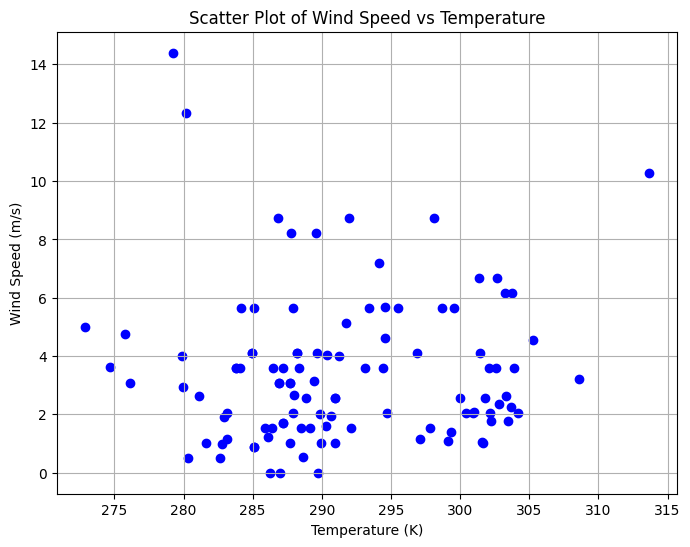

In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_weather_data(api_key, city):
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch weather data for {city}: {response.status_code}")
        return None

# Your OpenWeatherMap API key
api_key = "f5fb0414c3f1cc9c637fec763cb59663"

# List of cities for which you want to fetch weather data
additional_cities = [
    "Los Angeles", "Chicago", "Houston", "Phoenix", "Philadelphia",  # United States
    "Berlin", "Hamburg", "Munich", "Cologne", "Frankfurt",  # Germany
    "Toronto", "Montreal", "Vancouver", "Calgary", "Edmonton",  # Canada
    "Madrid", "Barcelona", "Valencia", "Seville", "Zaragoza",# Spain
    "Moscow", "Saint Petersburg", "Novosibirsk", "Yekaterinburg", "Nizhny Novgorod",  # Russia
    "Beijing", "Shanghai", "Guangzhou", "Shenzhen", "Hangzhou",  # China
    "Mumbai", "Delhi", "Bangalore", "Hyderabad", "Chennai",  # India
    "Mexico City", "Guadalajara", "Monterrey", "Puebla", "Tijuana",  # Mexico
    "São Paulo", "Rio de Janeiro", "Brasília", "Salvador", "Fortaleza",  # Brazil
    "Cairo", "Alexandria", "Giza", "Port Said",  # Egypt
    "Lagos", "Kano", "Ibadan", "Kaduna", "Port Harcourt",  # Nigeria
    "Tokyo", "Yokohama", "Osaka", "Nagoya", "Sapporo",  # Japan
    "Istanbul", "Ankara", "Izmir", "Bursa", "Antalya",  # Turkey
    "Manchester", "Birmingham", "Liverpool", "Leeds",  # United Kingdom
    "Paris", "Marseille", "Lyon", "Toulouse", "Nice",  # France
    "Berlin", "Hamburg", "Munich", "Cologne", "Frankfurt",  # Germany
    "Rome", "Milan", "Naples", "Turin", "Palermo",  # Italy
    "Sydney", "Melbourne", "Brisbane", "Perth", "Adelaide",  # Australia
    "Cape Town", "Johannesburg", "Durban", "Pretoria", "Port Elizabeth",  # South Africa
    "Bangkok", "Hanoi", "Ho Chi Minh City", "Jakarta", "Manila",  # Southeast Asia
    "Seoul", "Busan", "Incheon", "Daegu", "Daejeon",  # South Korea
]

# List of cities for which you want to fetch weather data
cities = ["London", "New York", "Tokyo", "Paris", "Sydney"] + additional_cities

# List to store weather data for all cities
weather_data_list = []

# Fetch weather data for each city
for city in cities:
    weather_data = fetch_weather_data(api_key, city)
    if weather_data:
        weather_data_list.append(weather_data)

# Convert weather data to a DataFrame
weather_df = pd.DataFrame(weather_data_list)

# Extract temperature and wind speed from the DataFrame
temperature = weather_df['main'].apply(lambda x: x['temp'])
wind_speed = weather_df['wind'].apply(lambda x: x['speed'])

# Scatter plot of wind speed vs temperature
plt.figure(figsize=(8, 6))
plt.scatter(temperature, wind_speed, color='blue')
plt.xlabel('Temperature (K)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Scatter Plot of Wind Speed vs Temperature')
plt.grid(True)
plt.show()

### LINKING THE POSTGRESQL TO MY JUPYTER NOTEBOOK THEN CREATING A TABLE QUERY

In [8]:
import psycopg2

# Connect to PostgreSQL on the local machine
conn = psycopg2.connect(
    dbname="postgres",  # Default database name
    user="postgres",  # Default user
    password="mypassword",  # The password you set
    host="localhost",  # Localhost if connecting from the same machine
    port="5432"  # Port number
)

# Create a cursor
cur = conn.cursor()

# Define a schema for your data if the table doesn't exist
create_table_query = """
CREATE TABLE IF NOT EXISTS weather_data (
    city VARCHAR(100),
    temperature FLOAT,
    wind_speed FLOAT
)
"""

# Execute the create table query
cur.execute(create_table_query)

# Commit the transaction
conn.commit()

# Insert data into the PostgreSQL table
for weather_data in weather_data_list:
    city = weather_data['name']
    temperature = weather_data['main']['temp']
    wind_speed = weather_data['wind']['speed']
    
    insert_query = """
    INSERT INTO weather_data (city, temperature, wind_speed)
    VALUES (%s, %s, %s)
    """
    data = (city, temperature, wind_speed)
    cur.execute(insert_query, data)

# Commit the transaction
conn.commit()

# Close the cursor and connection
cur.close()
conn.close()


### PUTTING THE CITIES, TEMPERATURE AND WIND SPEED DATA IN THE POSTGRESQL TABLE

In [9]:
import psycopg2
import pandas as pd

def fetch_data():
    try:
        # Connect to PostgreSQL on the local machine
        conn = psycopg2.connect(
            dbname="postgres",  # Default database name
            user="postgres",    # Default user
            password="mypassword",  # The password you set
            host="localhost",   # Localhost if connecting from the same machine
            port="5432"         # Port number
        )

        # Create a cursor
        cur = conn.cursor()

        # Check if the weather_data table exists
        cur.execute("SELECT EXISTS(SELECT 1 FROM information_schema.tables WHERE table_name = 'weather_data')")
        table_exists = cur.fetchone()[0]

        if table_exists:
            # If the table exists, fetch only temperature and wind_speed from it
            cur.execute("SELECT city, temperature, wind_speed FROM weather_data")
            rows = cur.fetchall()

            # Define the column names explicitly
            columns = ['city', 'temperature', 'wind_speed']

            # Create a DataFrame from the fetched data
            df = pd.DataFrame(rows, columns=columns)

            # Display the DataFrame
            print(df)
        else:
            print("The 'weather_data' table does not exist.")

        # Close the cursor and connection
        cur.close()
        conn.close()
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Ensure that the connection is closed
        if conn:
            conn.close()

if __name__ == "__main__":
    fetch_data()


         city  temperature  wind_speed
0      London       288.55        5.10
1      London       286.02        2.06
2    New York       295.06        3.09
3       Tokyo       293.27        5.66
4       Paris       286.34        2.57
..        ...          ...         ...
489     Seoul       281.66        1.03
490     Busan       284.14        5.66
491   Incheon       284.08        3.60
492     Daegu       282.62        0.51
493   Daejeon       281.12        2.63

[494 rows x 3 columns]


#### TO SHOW INTERACTION: THE CODE BELOW QUERIES THE POSTGRESQL TO FETCH THE TEMPERATURE AND WIND SPEED COLUMN

In [10]:
import psycopg2
import pandas as pd

def fetch_weather_data():
    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname="postgres", 
        user="postgres", 
        password="mypassword", 
        host="localhost", 
        port="5432"
    )
    cur = conn.cursor()

    # Execute query to retrieve temperature and wind_speed
    cur.execute("SELECT temperature, wind_speed FROM weather_data")
    data = cur.fetchall()
    
    # Close the connection
    cur.close()
    conn.close()

    # Load data into a DataFrame
    df = pd.DataFrame(data, columns=['temperature', 'wind_speed'])
    return df

# Fetch data
df = fetch_weather_data()
print(df.head())


   temperature  wind_speed
0       288.55        5.10
1       286.02        2.06
2       295.06        3.09
3       293.27        5.66
4       286.34        2.57


#### PERFORMING LINEAR REGRESSING WITH THE TEMPERATURE AND WIND SPEED TO CHECK FOR THE CORRELATION BETWEEN THEM.

Intercept: 290.23534597869286
Coefficient for wind speed: 0.5418079806625375


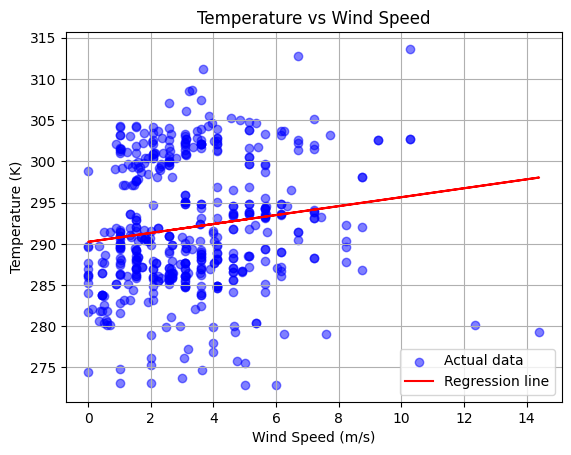

In [11]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def fetch_weather_data():
    try:
        conn = psycopg2.connect(
            dbname="postgres", 
            user="postgres", 
            password="mypassword", 
            host="localhost", 
            port="5432"
        )
        cur = conn.cursor()
        cur.execute("SELECT temperature, wind_speed FROM weather_data")
        data = cur.fetchall()
        cur.close()
        conn.close()
        return pd.DataFrame(data, columns=['temperature', 'wind_speed'])
    except psycopg2.Error as e:
        print("Error retrieving data from PostgreSQL:", e)
        return pd.DataFrame()

def plot_regression(X, y, predicted_y):
    plt.scatter(X, y, color='blue', label='Actual data', alpha=0.5)
    plt.plot(X, predicted_y, color='red', label='Regression line')
    plt.title('Temperature vs Wind Speed')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Temperature (K)')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    df = fetch_weather_data()
    if not df.empty:
        X = df[['wind_speed']]  # scikit-learn expects 2D array for X
        y = df['temperature']
        model = LinearRegression()
        model.fit(X, y)
        print(f'Intercept: {model.intercept_}')
        print(f'Coefficient for wind speed: {model.coef_[0]}')
        predicted_temps = model.predict(X)
        plot_regression(df['wind_speed'], df['temperature'], predicted_temps)

if __name__ == "__main__":
    main()


In linear regression, the intercept and coefficients represent the parameters of the linear equation that best fits the data. Here's what these results mean:

1. **Intercept**: The intercept represents the value of the dependent variable (temperature) when all independent variables (wind_speed) are zero. In this case, the intercept is approximately90.248. So, if the wind speed were zero, the model predicts the temperature to be arou d90.248 degrees (unit of measurement depends on your data).3

2. **Coefficient for wind speed**: The coefficient for wind speed represents the change in the dependent variable (temperature) for a one-unit change in the independent variable (wind_speed), holding all other variables constant. In this case, the coefficient is approximat0l5 1.14. So, for each unit increase in wind speed, the model predicts the temperature to increase by approximat0.541.14 degrees (again, unit of measurement depends on your data).

These results indicate that there is a positive linear relationship between temperature and wind speed in your data. As wind speed increases, the model predicts that temperature also increases. The intercept represents the baseline temperature, and the coefficient for wind speed represents the additional temperature change per unit increase in wind speed.

## PART 1

#### POSTGRESQL INTERACTION: PROMPT A USER TO INPUT A CITY AND CHECK IF IT IS IN POSTGRESQL. 

#### IF FOUND THERE SHOULD BE AN OUTPUT OF THE TEMPERATURE AND WIND SPEED.

#### IF NOT FOUND AN OUTPUT WOULD BE GIVEN TO INFORM THE USER.


In [16]:
import psycopg2

def fetch_weather_data(city_name):
    try:
        # Establish database connection
        conn = psycopg2.connect(
            dbname="postgres",
            user="postgres",
            password="mypassword",
            host="localhost",
            port="5432"
        )
        # Create a cursor
        cur = conn.cursor()
        
        # Normalize the input city_name to lower case and execute a case-insensitive query
        city_name_lower = city_name.lower()
        cur.execute("SELECT temperature, wind_speed FROM weather_data WHERE LOWER(city) = %s", (city_name_lower,))
        
        # Fetch one record
        record = cur.fetchone()
        
        # Close the cursor and connection
        cur.close()
        conn.close()

        # Check if a record was found
        if record:
            return record
        else:
            return None
    except psycopg2.Error as e:
        print("Database error:", e)
        return None

def main():
    while True:  # Start an infinite loop
        # Prompt the user to enter a city name or quit
        city_name = input("Please enter the name of the city or type 'End' to quit: ").strip()
        
        # Check if the user wants to exit the loop
        if city_name.lower() == 'end':
            print("Exiting the program.")
            break
        
        # Fetch weather data for the entered city
        result = fetch_weather_data(city_name)
        
        if result:
            temperature, wind_speed = result
            print(f"The temperature in {city_name} is {temperature} K and the wind speed is {wind_speed} m/s.")
        else:
            print(f"Sorry, there is no record for the city '{city_name}'.")
        
        # Ask the user if they are done or want to continue
        continue_input = input("Type 'End' if you are done or press Enter to continue: ").strip()
        if continue_input.lower() == 'end':
            print("Thank you for using the weather data program. Goodbye!")
            break

if __name__ == "__main__":
    main()


Please enter the name of the city or type 'End' to quit:  Lagos


The temperature in Lagos is 301.0 K and the wind speed is 2.38 m/s.


Type 'End' if you are done or press Enter to continue:  end


Thank you for using the weather data program. Goodbye!


## PART 2

#### POSTGRESQL INTERACTION: PROMPT A USER TO INPUT A CITY AND CHECK IF IT IS IN POSTGRESQL. IF FOUND THERE SHOULD BE AN OUTPUT OF THE TEMPERATURE AND WIND SPEED, IF NOT FOUND THE CITY INPUTTED WILL BE SEARCHED IN THE API. 

#### IF FOUND IN THE API, THE TEMPERATURE AND WIND SPEED WILL BE STORED IN THE POSTGRESQL THEN AN OUTPUT WILL SHOW THE TEMPERATURE AND WIND SPEED.

#### IF NOT FOUND IN THE API, IT WILL NOT BE STORED IN THE POSTGRESQL AND AN OUTPUT WILL INFORM THE USER 


In [17]:
import psycopg2
import requests
import pandas as pd

def fetch_weather_data(api_key, city):
    """ Fetch weather data from the OpenWeatherMap API. """
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch weather data for {city}: {response.status_code}")
        return None

def insert_weather_data(conn, city, temperature, wind_speed):
    """ Insert weather data into PostgreSQL database. """
    try:
        cur = conn.cursor()
        cur.execute("""
            INSERT INTO weather_data (city, temperature, wind_speed) VALUES (%s, %s, %s)
            """, (city, temperature, wind_speed))
        conn.commit()
        cur.close()
    except psycopg2.Error as e:
        print("Error inserting data into PostgreSQL:", e)

def check_local_database(conn, city_name):
    """ Check local PostgreSQL database for the city's weather data. """
    cur = conn.cursor()
    cur.execute("SELECT temperature, wind_speed FROM weather_data WHERE LOWER(city) = LOWER(%s)", (city_name,))
    record = cur.fetchone()
    cur.close()
    return record

def main():
    api_key = 'your_api_key_here'  # Replace with your OpenWeatherMap API key
    conn = psycopg2.connect(
        dbname="postgres", 
        user="postgres", 
        password="mypassword", 
        host="localhost", 
        port="5432"
    )

    while True:
        city_name = input("Please enter the name of the city or type 'end' to quit: ").strip()
        if city_name.lower() == 'end':
            print("Exiting the program.")
            break
        record = check_local_database(conn, city_name)
        if record:
            print(f"The temperature in {city_name} is {record[0]}°K and the wind speed is {record[1]} m/s.")
        else:
            weather_data = fetch_weather_data(api_key, city_name)
            if weather_data and 'main' in weather_data and 'wind' in weather_data:
                temperature = weather_data['main']['temp']
                wind_speed = weather_data['wind']['speed']
                # Insert data into the PostgreSQL database
                insert_weather_data(conn, city_name, temperature, wind_speed)
                print(f"The temperature in {city_name} is {temperature}°C and the wind speed is {wind_speed} m/s.")
            else:
                print("Sorry, there are no results for your output.")

    conn.close()

if __name__ == "__main__":
    main()


Please enter the name of the city or type 'end' to quit:  Singapore


The temperature in Singapore is 301.22°K and the wind speed is 1.03 m/s.


Please enter the name of the city or type 'end' to quit:  end


Exiting the program.
